In [3]:
import pandas as pd

In [4]:
# Load the dataset (adjust the file path if needed)
data = pd.read_csv('data/train.csv', parse_dates=['Date'], low_memory=False)

# Display the first few rows to inspect the data
print(data.head())
print(data.info())

   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  in

In [5]:
# Calculate average sales per store and simulate an inventory level
store_inventory = data.groupby('Store')['Sales'].mean() * 1.2

# Merge the simulated inventory back into the main dataset
data = data.merge(store_inventory.rename("Inventory"), left_on="Store", right_index=True)

# Create a binary target 'stockout': 1 if Sales exceed Inventory, else 0
data['stockout'] = (data['Sales'] > data['Inventory']).astype(int)

# Check the new columns
print(data[['Store', 'Sales', 'Inventory', 'stockout']].head())


   Store  Sales    Inventory  stockout
0      1   5263  4734.845860         1
1      2   6064  4947.589809         1
2      3   8314  6889.504459         1
3      4  13995  9626.123567         1
4      5   4822  4640.532484         1


In [6]:
# Extract date features
data['DayOfWeek'] = data['Date'].dt.dayofweek   # Monday=0, Sunday=6
data['Month'] = data['Date'].dt.month

# Convert 'StateHoliday' to string and one-hot encode it (and DayOfWeek as categorical)
data['StateHoliday'] = data['StateHoliday'].astype(str)

# One-hot encoding for StateHoliday and DayOfWeek (excluding one category to avoid redundancy)
data = pd.get_dummies(data, columns=['StateHoliday', 'DayOfWeek'], drop_first=True)

# Check the transformed data
print(data.head())


   Store       Date  Sales  Customers  Open  Promo  SchoolHoliday  \
0      1 2015-07-31   5263        555     1      1              1   
1      2 2015-07-31   6064        625     1      1              1   
2      3 2015-07-31   8314        821     1      1              1   
3      4 2015-07-31  13995       1498     1      1              1   
4      5 2015-07-31   4822        559     1      1              1   

     Inventory  stockout  Month  StateHoliday_a  StateHoliday_b  \
0  4734.845860         1      7           False           False   
1  4947.589809         1      7           False           False   
2  6889.504459         1      7           False           False   
3  9626.123567         1      7           False           False   
4  4640.532484         1      7           False           False   

   StateHoliday_c  DayOfWeek_1  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  \
0           False        False        False        False         True   
1           False        False      

In [7]:
from sklearn.preprocessing import StandardScaler

# Define numerical features to scale (you can add more if needed)
num_features = ['Sales', 'Customers']
scaler = StandardScaler()

# Scale the features and update the DataFrame
data[num_features] = scaler.fit_transform(data[num_features])

print(data[num_features].head())


      Sales  Customers
0 -0.132683  -0.168269
1  0.075373  -0.017540
2  0.659800   0.404499
3  2.135414   1.862258
4 -0.247231  -0.159656


In [8]:
# Define feature columns (drop Date, Sales, and stockout as target will be defined separately)
features = data.drop(['Date', 'Sales', 'stockout'], axis=1)
target = data['stockout']

print(features.head())
print(target.head())


   Store  Customers  Open  Promo  SchoolHoliday    Inventory  Month  \
0      1  -0.168269     1      1              1  4734.845860      7   
1      2  -0.017540     1      1              1  4947.589809      7   
2      3   0.404499     1      1              1  6889.504459      7   
3      4   1.862258     1      1              1  9626.123567      7   
4      5  -0.159656     1      1              1  4640.532484      7   

   StateHoliday_a  StateHoliday_b  StateHoliday_c  DayOfWeek_1  DayOfWeek_2  \
0           False           False           False        False        False   
1           False           False           False        False        False   
2           False           False           False        False        False   
3           False           False           False        False        False   
4           False           False           False        False        False   

   DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  
0        False         True        False  

In [9]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Apply SMOTE to the training set to address class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_res).value_counts())

Before SMOTE: stockout
0    507108
1    306659
Name: count, dtype: int64
After SMOTE: stockout
0    507108
1    507108
Name: count, dtype: int64


In [13]:
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# Logistic Regression
lr = LogisticRegression(max_iter=5000, random_state=42, solver='saga')
lr.fit(X_train_res, y_train_res)
lr_pred = lr.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_pred)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_res, y_train_res)
dt_pred = dt.predict_proba(X_test)[:, 1]
dt_auc = roc_auc_score(y_test, dt_pred)

# LightGBM
lgb_train = lgb.Dataset(X_train_res, label=y_train_res)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1,
    'seed': 42
}
lgb_model = lgb.train(params, lgb_train, num_boost_round=100)
lgb_pred = lgb_model.predict(X_test)
lgb_auc = roc_auc_score(y_test, lgb_pred)

print(f'Logistic Regression AUC: {lr_auc:.2f}')
print(f'Decision Tree AUC: {dt_auc:.2f}')
print(f'LightGBM AUC: {lgb_auc:.2f}')

C:\Users\faree\Downloads\Fareed\Projects\stockout-prediction\env\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression AUC: 0.92
Decision Tree AUC: 0.90
LightGBM AUC: 0.96


In [14]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Decision Tree
param_grid = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, scoring='roc_auc', cv=5)
grid_dt.fit(X_train_res, y_train_res)
print("Best Decision Tree parameters:", grid_dt.best_params_)


Best Decision Tree parameters: {'max_depth': None, 'min_samples_split': 10}


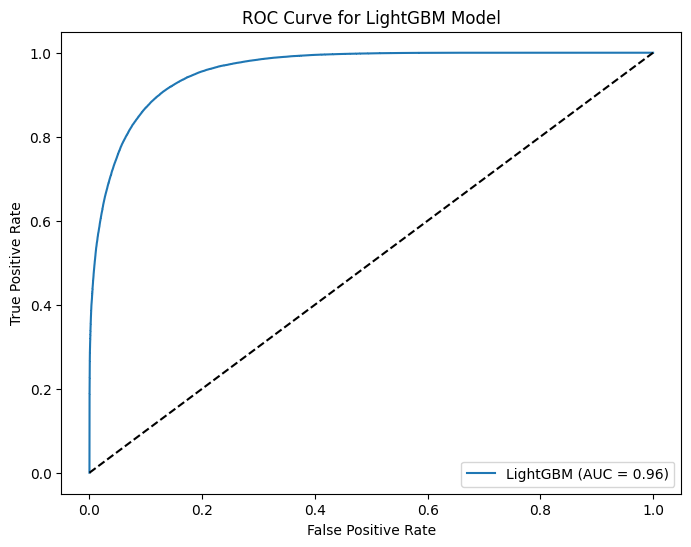

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, lgb_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {lgb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM Model')
plt.legend()
plt.show()

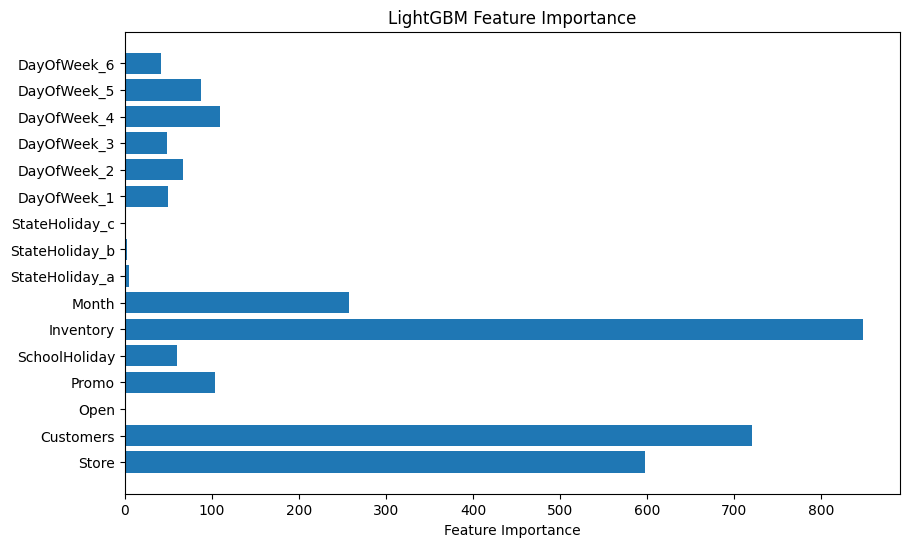

In [17]:
# Get feature importances from LightGBM
importances = lgb_model.feature_importance()
feature_names = X_train_res.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance')
plt.show()
